In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import dlop_ldn_function_bases as bases

In [2]:
def mk_fourier_oscillator(q, mul=1.0):
    B = (np.arange(0, q) + 1) % 2
    A = np.zeros((q, q))
    for k in range(1, q):
        ki = (k + 1) // 2
        fk = 2.0 * np.pi * mul * ki
        A[2 * ki - 1, 2 * ki - 1] = 0
        A[2 * ki - 1, 2 * ki + 0] =  fk
        A[2 * ki + 0, 2 * ki - 1] = -fk
        A[2 * ki + 0, 2 * ki + 0] = 0
    return A, B

In [3]:
def eval_lti(A, B, ts):
    import scipy.linalg
    return np.array([scipy.linalg.expm(A * t) @ B for t in ts])

In [4]:
N, q, dt, T = 1000, 101, 1e-3, 1.0
A, B = mk_fourier_oscillator(q, mul=0.9)
Ad, Bd = np.zeros((q, q)), np.zeros((q,))
Ad[1:, 1:], Bd[1:] = bases.discretize_lti(dt, A[1:, 1:], B[1:])
Bd[0] = 1e-3
Ad[0, 0] = 1.0
H = bases.mk_lti_basis(Ad, Bd, N, from_discrete_lti=True, normalize=False)

In [5]:
enc = H[:, 0]
dec = np.linalg.pinv(H, rcond=1e-2)[0]
Ad = Ad - np.outer(enc, dec) @ Ad
Bd = Bd - np.outer(enc, dec) @ Bd

In [6]:
A = np.real(scipy.linalg.logm(Ad)) * N / T
B = scipy.linalg.expm(-0.5 * A * T / N) @ Bd * np.sqrt(N)

In [7]:
def mk_mod_fourier_lti(q, fac=0.9, Ninternal=1000):
    def mk_fourier_oscillator(q, mul=1.0):
        B = (np.arange(0, q) + 1) % 2
        A = np.zeros((q, q))
        for k in range(1, q):
            ki = (k + 1) // 2
            fk = 2.0 * np.pi * mul * ki
            A[2 * ki - 1, 2 * ki - 1] = 0
            A[2 * ki - 1, 2 * ki + 0] = fk
            A[2 * ki + 0, 2 * ki - 1] = -fk
            A[2 * ki + 0, 2 * ki + 0] = 0
        return A, B

    assert q % 2 == 1

    A, B = mk_fourier_oscillator(q, mul=0.9)
    Ad, Bd = np.zeros((q, q)), np.zeros((q, ))

    Ad[1:, 1:], Bd[1:] = bases.discretize_lti(1.0 / Ninternal, A[1:, 1:],
                                              B[1:])
    Bd[0] = 1e-3
    Ad[0, 0] = 1.0

    H = bases.mk_lti_basis(Ad,
                           Bd,
                           Ninternal,
                           from_discrete_lti=True,
                           normalize=False)
    enc = H[:, 0]
    dec = np.linalg.pinv(H, rcond=1e-2)[0]

    Ad = Ad - np.outer(enc, dec) @ Ad
    Bd = Bd - np.outer(enc, dec) @ Bd

    A = np.real(scipy.linalg.logm(Ad)) * Ninternal
    return A, B

In [8]:
def mk_mod_fourier_basis(q, N, Nmul=1, fac=0.9, Ninternal=1000):
    A, B = mk_mod_fourier_lti(q, fac, Ninternal)
    return bases.mk_lti_basis(A, B, N, N * Nmul)

3.267044396109447


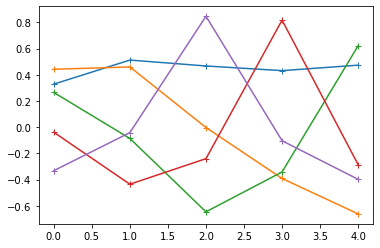

In [13]:
H = bases.mk_ldn_basis(5, 5)
_, S, _ = np.linalg.svd(H)
print(np.sum(S / np.max(S)))
#H2 = bases.mk_fourier_basis(5, 5)
fig, ax = plt.subplots()
ax.plot(H.T, '+-')
#ax.set_prop_cycle(None)
#ax.plot(H2.T, '+--')

In [ ]:
Ao, Bo = mk_mod_fourier_lti(101, 1000)
fig, ax = plt.subplots()
ax.imshow(Ao)

In [ ]:
def mexpfin(A, o):
    if o == 0:
        return np.eye(A.shape[0])
    res = np.zeros_like(A)
    f = 1.0
    for i in range(1, o + 1):
        res += np.linalg.matrix_power(A, i) * f
        f /= (i + 1)
    return res

In [ ]:
# Compute the basis transformation matrix
q = Ao.shape[0]
N = 200
A, B = Ao / N, Bo / N
A = mexpfin(A, 4)
At, Bt = A + np.eye(q), B
H = np.zeros((q, 3*N))
Aexp = np.eye(q)
for i in range(3*N):
    H[:, i] = Aexp @ Bt
    Aexp = At @ Aexp
H = H / np.linalg.norm(H, axis=1)[:, None]

In [ ]:
H

In [ ]:
fig, ax = plt.subplots()
ax.plot(H.T);

In [ ]:
H = mk_mod_fourier_basis(461, 1000, Nmul=2)
fig, ax = plt.subplots()
ax.plot(H[:100].T);